In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#from mpl_toolkits.mplot3d import axes3d

In [2]:
import pymc as pm

In [3]:
gaia = pd.read_csv('../data/gaiaedr3_solar_neighborhood.csv')
# want parallax > 40 milliarcseconds.
gaia_nearby_sel = gaia.parallax > 40.
gaia_nearby = gaia[gaia_nearby_sel]
gaia_nearby

,mg,bp_rp,parallax
27,8.232225,1.978331,90.021153
143,12.100067,3.068046,42.575840
248,10.201480,2.611247,40.996986
307,9.548687,2.321217,46.926325
355,10.486186,2.735957,51.720196
...,...,...,...
227352,10.517037,2.775828,59.990509
227375,5.080503,0.869664,59.884975
227470,10.063029,2.511210,58.055094
227476,10.821683,2.551090,44.925570


<font size='5'> Part I

for mg < m_div * bp-rp + b_div.
        #mg = y
        bp-rp = x
Use a simple linear boundary to divide the population:

In [4]:
mg = gaia_nearby.mg
bp_rp = gaia_nearby.bp_rp

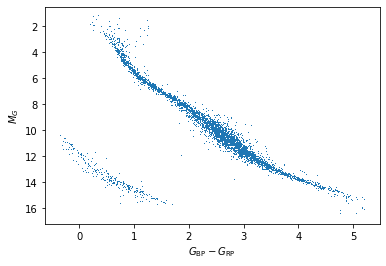

In [5]:
plt.plot(bp_rp, mg, lw=0, marker=',')
plt.gca().invert_yaxis()
plt.xlabel(r"$G_\mathrm{BP} - G_\mathrm{RP}}$")
plt.ylabel("$M_G$");

In [6]:
x1, y1 = 0, 8
x2, y2 = 3, 16.5
x = np.array([1. , 3.])
y = np.array([8. , 16.5])

#sigma = data['mg'].std()

m_div = (y2 - y1)/(x2 - x1) # sample slope
b_div = y1 - m_div * x1# y intercept

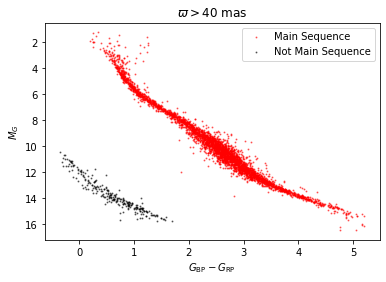

In [7]:
ms_sel = mg < m_div * bp_rp + b_div
#ms_sel is data focusing on
#~ms_sel inverts
plt.scatter(bp_rp[ms_sel], mg[ms_sel], s=1, alpha=0.5, color='r', label='Main Sequence')
        #this is mg < m_div * bp_rp + b_div
plt.scatter(bp_rp[~ms_sel], mg[~ms_sel], s=1, alpha=0.5, color='k', label='Not Main Sequence')
plt.gca().invert_yaxis()
plt.title(r'$\varpi > 40$ mas')
plt.xlabel(r"$G_\mathrm{BP} - G_\mathrm{RP}}$")
plt.ylabel(r"$M_G$")
plt.legend();

In [8]:
bp_rp = bp_rp[ms_sel]#'x' values
mg = mg[ms_sel]#'y' values
sigm_y=mg.std()

In [10]:
bp_rp

27        1.978331
143       3.068046
248       2.611247
307       2.321217
355       2.735957
            ...   
227352    2.775828
227375    0.869664
227470    2.511210
227476    2.551090
227559    0.899772
Name: bp_rp, Length: 3820, dtype: float64

1. Construct a PyMC model that models the population as a line, assuming MG to be distributed normally about this line with a standard deviation to be inferred from the data.  Perform an MCMC.

In [9]:
#need to adjust to new xy, get array of std
with pm.Model() as linear_model:
    # prior ie unknowns, (but we know normally distributed)
    
    b = pm.Normal('b', mu=2.5, sd=14)# mu-crosses y, sd-whole y
    m = pm.Normal('m',sd=1)#length of 1x 
    
    mu = m * bp_rp + b
    
    
    y = pm.Normal('y', mu=mu, sd=sigm_y, observed=mg)

ValueError: Length of Elemwise{mul,no_inplace}.0 cannot be determined

In [45]:
with linear_model:
    trace = pm.sample()

MissingInputError: Input 0 (m_div) of the graph (indices start from 0), used to compute InplaceDimShuffle{x}(m_div), was not provided and not given a value. Use the Aesara flag exception_verbosity='high', for more information on this error.
 
Backtrace when that variable is created:

  File "/opt/conda/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
    coro.send(None)
  File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3098, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3301, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3361, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_4970/969677001.py", line 4, in <cell line: 1>
    m = pm.Normal('m_div')
  File "/opt/conda/lib/python3.9/site-packages/pymc/distributions/distribution.py", line 275, in __new__
    rv_out = model.register_rv(
  File "/opt/conda/lib/python3.9/site-packages/pymc/model.py", line 1251, in register_rv
    self.create_value_var(rv_var, transform)
  File "/opt/conda/lib/python3.9/site-packages/pymc/model.py", line 1408, in create_value_var
    value_var = rv_var.type()


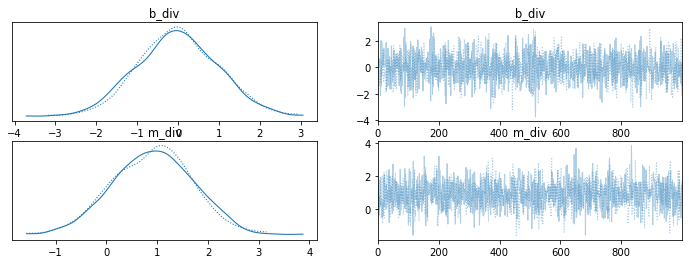

In [11]:
with linear_model:
    pm.plot_trace(trace)

2. Construct a new model that models the relation between BP-RP and MG quadratically.  Carefully choose priors; be sure to explore choices for locations and scales that are appropriate for the new parameters.  Run an MCMC.

In [8]:
with pm.Model() as quad_model:
    a = pm.Normal('a', sd=14)
    b = pm.Normal('b', sd=14)
    c = pm.Normal('c', sd=14**2)
    
    sigma = pm.HalfNormal('scatter', sd=2)
    
    t = pm.MutableData('t', bp_rp, dims='obs_time')
    μ = pm.Deterministic('μ', a*t**2 + b*t + c, dims='obs_time')
    
    obs = pm.Normal('mg', mu=μ, sd=sigm_y, observed=mg, dims='obs_time')

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, b, c, scatter]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 93 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


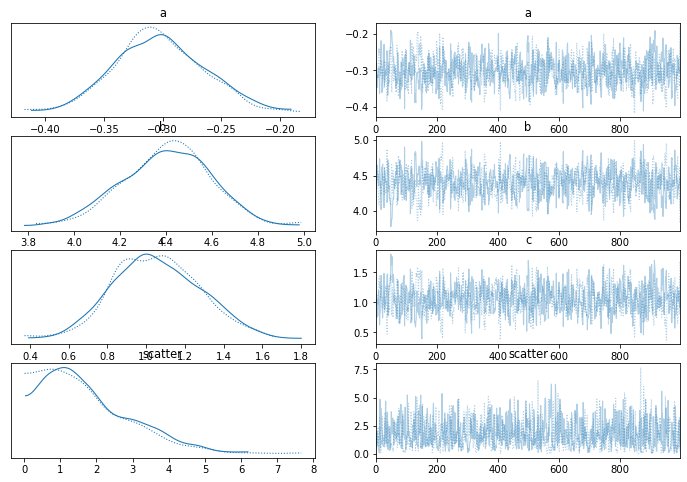

In [9]:
with quad_model:
    quad_trace = pm.sample(1000)
    pm.plot_trace(quad_trace, var_names=['~μ'])